In [1]:
!pip install torch_optimizer

/Users/tanishrajput/.zshenv:1: bad assignment

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install timm

/Users/tanishrajput/.zshenv:1: bad assignment

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
import timm
import random
import time
from collections import OrderedDict
from torch.cuda import amp
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.optim.optimizer
from torchvision import datasets, transforms as T
import matplotlib.pyplot as plt
from torchvision.io import read_image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sns
from tqdm import tqdm
import concurrent.futures
from torch.utils.data import random_split
from sklearn.metrics import classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
import torchvision.models as models
from torch.utils.data import WeightedRandomSampler
import torch_optimizer as optim

In [4]:
print(torch.__version__)

2.4.0


In [4]:
def seed_everything(seed):
    """
    Sets seeds for reproducibility in training.

    Args:
        seed (int): Seed value to ensure determinism.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)  # Seed for hash-based operations
    np.random.seed(seed)  # Seed for NumPy
    torch.manual_seed(seed)  # Seed for PyTorch (CPU)
    torch.cuda.manual_seed(seed)  # Seed for PyTorch (GPU)
    torch.backends.cudnn.deterministic = True  # Make CuDNN deterministic
    torch.backends.cudnn.benchmark = True  # Enable benchmark mode for CuDNN

In [5]:
seed_everything(42)

# EDA

In [6]:
train= pd.read_csv('Dataset/train.csv')
test= pd.read_csv('Dataset/test.csv')

In [7]:
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

In [8]:
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=train, palette="GnBu_d")
sns.despine()
plt.show()

/var/folders/yy/x1rxps2s2kb9r69ysncj7qs00000gn/T/ipykernel_93813/3771657651.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="diagnosis", data=train, palette="GnBu_d")


In [9]:
# Setting the style for the plot
sns.set_style("white")

# Mapping class labels to their corresponding categories
level_to_category = {
    0: "No_DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}

# Plotting the first 15 images along with their labels
count = 1
plt.figure(figsize=[20, 20])

for img_name in train['id_code'][:15]:  # Assuming 'train' contains the dataset
    img = cv2.imread(f"Dataset/train_images/{img_name}.png")[..., [2, 1, 0]]  # Reading the image
    
    # Getting the label (class) for the image
    label = train[train['id_code'] == img_name]['diagnosis'].values[0]  # Assuming 'diagnosis' is the label column
    
    # Setting up the subplot with image and label
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title(f"Image {count}: {level_to_category[label]}")  # Display the class label
    count += 1
# Display the plot
plt.savefig('imagebeforepreprecssing.png')
plt.show()

# Data Preprocessing

In [11]:
# Function to crop the image based on grayscale threshold
def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:  # Image is too dark so that we crop out everything
            return img  # Return original image
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img

In [12]:
# Set input and output directories
input_dir = 'Dataset/train_images/'
output_dir = 'processed_images/'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load the CSV containing image names and labels
csv_path = 'Dataset/train.csv'
df = pd.read_csv(csv_path)

# Create a CLAHE object
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# Function to process a single image
def process_image(row):
    sample_image_id = row['id_code']  # Get the image ID
    sample_image_file = sample_image_id + '.png'  # Assuming the image files have .png extension
    sample_image_path = os.path.join(input_dir, sample_image_file)

    if os.path.exists(sample_image_path):
        # Load the image
        image = cv2.imread(sample_image_path)
        
        # Crop the image based on gray threshold
        image_cropped = crop_image_from_gray(image)
        
        # Resize the image to 256x256
        image_resized = cv2.resize(image_cropped, (224, 224))
        
        # Split the image into its channels (BGR format)
        blue, green, red = cv2.split(image_resized)
        
        # Apply CLAHE to all three channels
        blue_clahe = clahe.apply(blue)
        green_clahe = clahe.apply(green)
        red_clahe = clahe.apply(red)
        
        # Merge the CLAHE-enhanced channels back together
        result_image = cv2.merge([blue_clahe, green_clahe, red_clahe])
        
        # Save the processed image to the output directory
        output_path = os.path.join(output_dir, sample_image_file)
        cv2.imwrite(output_path, result_image)

# Using ThreadPoolExecutor to process images in parallel
with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    # Using tqdm to show progress bar while processing images
    list(tqdm(executor.map(process_image, [row for _, row in df.iterrows()]), total=df.shape[0], desc="Processing images", unit="image"))

print("Processing complete for all images.")

Processing images: 100%|█████████████████| 3662/3662 [00:51<00:00, 70.57image/s]

Processing complete for all images.


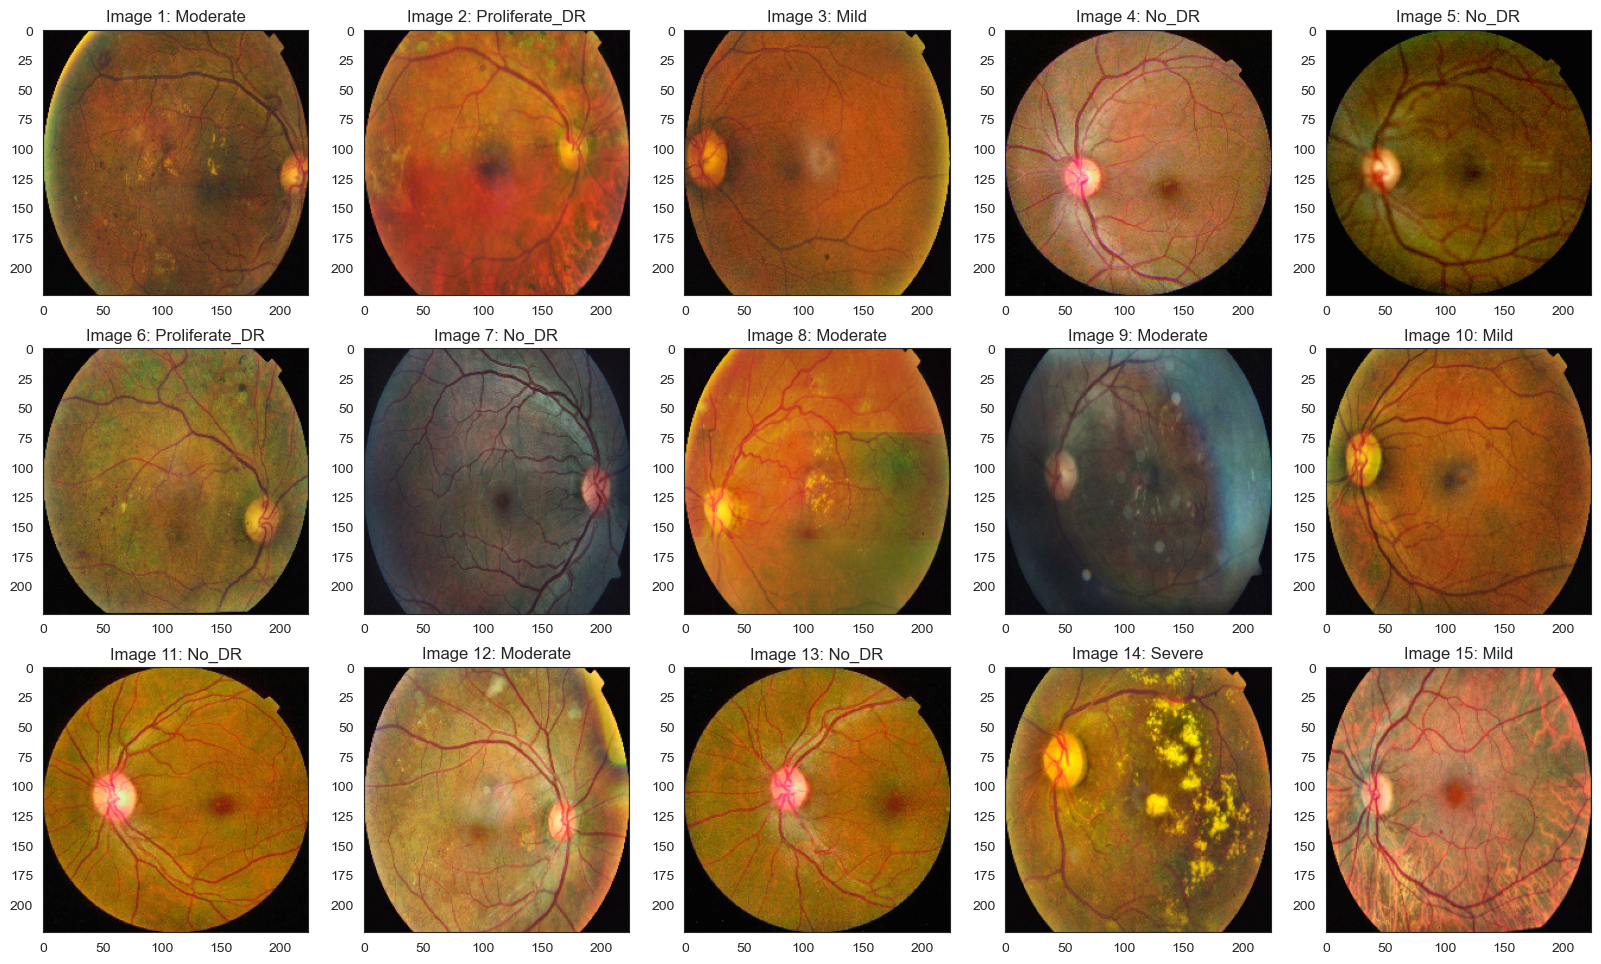

In [13]:
# Setting the style for the plot
sns.set_style("white")

# Mapping class labels to their corresponding categories
level_to_category = {
    0: "No_DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}

# Plotting the first 15 images along with their labels
count = 1
plt.figure(figsize=[20, 20])

for img_name in train['id_code'][:15]:  # Assuming 'train' contains the dataset
    img = cv2.imread(f"Dataset/processed_images/{img_name}.png")[..., [2, 1, 0]]  # Reading the image
    
    # Getting the label (class) for the image
    label = train[train['id_code'] == img_name]['diagnosis'].values[0]  # Assuming 'diagnosis' is the label column
    
    # Setting up the subplot with image and label
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title(f"Image {count}: {level_to_category[label]}")  # Display the class label
    count += 1

# Display the plot
plt.show()

# Data Splitting and Transformation

In [14]:
DATA_DIR = "Dataset"
TRAIN_DIR = "Dataset/processed_images"
CSV_PATH = "Dataset/train.csv"
MODEL_PATH = "/"
LEARNING_RATE = 1e-4
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TRAIN_SPLIT = 0.8
NUM_WORKERS = 0
USE_AMP = True
EPOCHS=20

In [15]:
class RetinopathyDataset(Dataset):
    def __init__(self, image_dir, csv_file, transforms=None):
        self.data = pd.read_csv(csv_file)
        self.transforms = transforms
        self.image_dir = image_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # img_name = os.path.join('../input/aptos2019-blindness-detection/train_images',
        #                         self.data.loc[idx, 'id_code'] + '.png')

        img_name = os.path.join(self.image_dir, self.data.loc[idx, 'id_code'] + '.png')

        tensor_image = read_image(img_name)
        label = torch.tensor(self.data.loc[idx, 'diagnosis'], dtype=torch.long)

        if self.transforms is not None:
            tensor_image = self.transforms(tensor_image)

        return (tensor_image, label)

In [16]:
train_trasforms_DeiT_base_patch16= T.Compose([
    T.ConvertImageDtype(torch.float32),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = RetinopathyDataset(TRAIN_DIR, CSV_PATH, transforms=train_trasforms_DeiT_base_patch16)

train_size = int(TRAIN_SPLIT * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(full_dataset, batch_size=TRAIN_BATCH_SIZE,
                         num_workers=NUM_WORKERS, drop_last=True, pin_memory=False)

val_loader = DataLoader(val_dataset, batch_size=VALID_BATCH_SIZE, 
                        num_workers=NUM_WORKERS, drop_last=True, pin_memory=False)

## Helper Functions and Utilities for Training and Evaluation

In [17]:
@torch.no_grad()
def accuracy(output, target):
    """
    Computes the overall accuracy of predictions.

    Args:
        output (torch.Tensor): Model predictions with shape (batch_size, num_classes).
        target (torch.Tensor): True labels with shape (batch_size,).

    Returns:
        float: Accuracy as a percentage.
    """
    with torch.no_grad():
        _, predicted = output.max(1)  # Get the class index with the highest score
        correct = predicted.eq(target).sum().item()  # Count correct predictions
        total = target.size(0)  # Total number of samples
        accuracy = 100.0 * correct / total  # Compute accuracy percentage

    return accuracy


def set_debug_apis(state: bool = False):
    """
    Configures PyTorch debugging tools.

    Args:
        state (bool): If True, enables debugging tools for profiling and anomaly detection.
    """
    torch.autograd.profiler.profile(enabled=state)
    torch.autograd.profiler.emit_nvtx(enabled=state)
    torch.autograd.set_detect_anomaly(mode=state)

In [36]:
print(torch.cuda.is_available())

False


# Fine Tuning the Models

Training function and validations

In [18]:
def train_step(model: torch.nn.Module, train_loader, criterion, device: str, optimizer, scheduler=None, num_batches: int = None, log_interval: int = 100, scaler=None):
    """
    Performs one step of training with progress tracking using tqdm, and updates progress at each epoch.
    """
    model = model.to(device)
    model.train()

    start_train_step = time.time()
    metrics = OrderedDict()

    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    # Initialize tqdm progress bar for the training loop (per epoch)
    with tqdm(train_loader, desc="Training", unit="batch") as pbar:
        for batch_idx, (inputs, target) in enumerate(pbar):
            inputs = inputs.to(device)
            target = target.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Mixed precision training if scaler is provided
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    output = model(inputs)
                    loss = criterion(output, target)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                output = model(inputs)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

            # Update the scheduler if it's provided
            if scheduler is not None:
                scheduler.step()

            # Update metrics
            total_loss += loss.item() * inputs.size(0)
            _, predicted = output.max(1)
            correct_predictions += predicted.eq(target).sum().item()
            total_samples += inputs.size(0)

            # Update progress bar (per batch)
            pbar.set_postfix({
                "Loss": f"{total_loss / total_samples:.4f}",
                "Accuracy": f"{100.0 * correct_predictions / total_samples:.2f}%"
            })

            # Break if num_batches is set and we've reached the limit
            if num_batches is not None and batch_idx + 1 >= num_batches:
                break

    # Final metrics for the epoch
    end_train_step = time.time()
    metrics["loss"] = total_loss / total_samples
    metrics["accuracy"] = 100.0 * correct_predictions / total_samples

    # Print the time taken for the train step and the summary of the metrics
    print(f"\nEpoch Summary: Time taken for train step = {end_train_step - start_train_step:.2f} sec")
    print(f"Training loss = {metrics['loss']:.4f}, Training accuracy = {metrics['accuracy']:.2f}%")

    return metrics

In [26]:
@torch.no_grad()  # No gradient calculation needed during validation
def val_step(model: torch.nn.Module, val_loader, criterion, device: str, num_batches=None, log_interval: int = 100):
    """
    Performs one step of validation with progress tracking using tqdm.

    Args:
        model: A PyTorch CNN Model.
        val_loader: DataLoader for the validation set.
        criterion: Loss function to evaluate.
        device: "cuda" or "cpu".
        num_batches: (optional) Limit validation to a certain number of batches.
        log_interval: (optional) Log after every specified number of batches.
    """
    
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode

    start_val_step = time.time()  # Track the start time of the validation step
    metrics = OrderedDict()

    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    # Initialize tqdm progress bar for the validation loop (per epoch)
    with tqdm(val_loader, desc="Validation", unit="batch") as pbar:
        for batch_idx, (inputs, target) in enumerate(pbar):
            inputs = inputs.to(device)
            target = target.to(device)

            # Forward pass (no gradient computation)
            output = model(inputs)
            loss = criterion(output, target)

            # Update metrics
            total_loss += loss.item() * inputs.size(0)
            _, predicted = output.max(1)  # Get predictions
            correct_predictions += predicted.eq(target).sum().item()  # Compare predictions with targets
            total_samples += inputs.size(0)

            # Update progress bar with the current loss and accuracy
            pbar.set_postfix({
                "Loss": f"{total_loss / total_samples:.4f}",
                "Accuracy": f"{100.0 * correct_predictions / total_samples:.2f}%"
            })

            # Break if num_batches is specified and we've reached the limit
            if num_batches is not None and batch_idx + 1 >= num_batches:
                break

    # Final metrics for the epoch
    end_val_step = time.time()  # Track the end time of the validation step
    metrics["loss"] = total_loss / total_samples
    metrics["accuracy"] = 100.0 * correct_predictions / total_samples

    # Print the time taken and the final validation metrics
    print(f"\nValidation Summary: Time taken for validation step = {end_val_step - start_val_step:.2f} sec")
    print(f"Validation loss = {metrics['loss']:.4f}, Validation accuracy = {metrics['accuracy']:.2f}%")

    return metrics

Fine Tuning SWIN

In [19]:
# Define the models
Model_P= "pit_b_224"
MODEL_NAME='Mobile_Pit'
set_debug_apis(False)

# Handle imbalanced Classes

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
#  (but you want MobileNet here)
Model_Mobile = models.mobilenet_v2(pretrained=True)  # Use MobileNetV2 from torchvision
num_features_mobile = Model_Mobile.classifier[1].in_features  # Access the final layer's in_features
Model_Mobile.classifier = nn.Identity()  # Replace the fully connected layer with Identity to get features

# PiT (DeiT-style) Model Setup using timm
Model_pit = timm.create_model(Model_P, pretrained=True, num_classes=5)
num_features_pit = Model_pit.head.in_features  # Access the head layer's in_features
Model_pit.head = nn.Identity()  # Replace the head with Identity to get features

# Combined Model Class
class CombinedModel(nn.Module):
    def __init__(self, Model_Mobile, Model_pit, num_classes):
        super(CombinedModel, self).__init__()
        self.Model_Mobile = Model_Mobile
        self.Model_pit = Model_pit
        # Linear layer to classify after concatenating features
        self.fc = nn.Linear(num_features_mobile + num_features_pit, num_classes)

    def forward(self, x):
        # Extract features from MobileNetV2
        Model_Mobile_features = self.Model_Mobile(x)
        # Extract features from PiT
        Model_pit_features = self.Model_pit(x)

        # Ensure outputs are 2D (batch_size, num_features)
        if len(Model_Mobile_features.shape) > 2:
            Model_Mobile_features = Model_Mobile_features.flatten(1)  # Flatten spatial dimensions
        if len(Model_pit_features.shape) > 2:
            Model_pit_features = Model_pit_features.flatten(1)

        # Concatenate features along the feature axis (dim=1)
        combined_features = torch.cat((Model_Mobile_features, Model_pit_features), dim=1)

        # Pass through the final linear layer
        output = self.fc(combined_features)
        return output

# Instantiate the combined model
device = "cuda" if torch.cuda.is_available() else "cpu"
model_co = CombinedModel(Model_Mobile, Model_pit, num_classes=5).to(device)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
# Extract the class labels (diagnosis column)
class_labels = train['diagnosis'].values

# Compute class weights using sklearn
unique_classes = np.unique(class_labels)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=class_labels)

# Create a dictionary that maps class labels to their corresponding weights
class_weight_dict = {class_label: weight for class_label, weight in zip(unique_classes, class_weights)}

print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.4057617728531856, 1: 1.9794594594594594, 2: 0.7331331331331331, 3: 3.7948186528497407, 4: 2.4827118644067796}


In [23]:
!pip install torch_optimizer

/Users/tanishrajput/.zshenv:1: bad assignment

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [24]:
weights_tensor = torch.tensor(list(class_weight_dict.values())).float()
criterion= nn.CrossEntropyLoss(weight=weights_tensor.to(device))
import torch.optim as optim  # Use torch.optim, not torch_op

import torch_optimizer as optim
optimizer=  optim.Lamb(model_co.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

if USE_AMP:
    from torch.cuda import amp
    scaler = amp.GradScaler()

/var/folders/yy/x1rxps2s2kb9r69ysncj7qs00000gn/T/ipykernel_93813/3198915562.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [46]:
import torch
from tqdm import tqdm
import time

# Initialize loss and accuracy history before starting the loop
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

# Start epoch loop with tqdm tracking total iterations per epoch
train_batches = len(train_loader)
val_batches = len(val_loader)

# Start timer for overall training time
start_time = time.time()

for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    print(f"Epoch {epoch+1}/{EPOCHS}")

    # Training loop
    with tqdm(total=train_batches, desc=f"Training Epoch {epoch+1}", unit="batch") as pbar_train:
        train_metrics = train_step(model_co, train_loader, criterion, device, optimizer, scaler=scaler)
        train_loss.append(train_metrics['loss'])
        train_accuracy.append(train_metrics['accuracy'])
        pbar_train.set_postfix({"Loss": f"{train_metrics['loss']:.4f}", "Accuracy": f"{train_metrics['accuracy']:.2f}%"})
        pbar_train.update()

    # Validation loop
    with tqdm(total=val_batches, desc=f"Validation Epoch {epoch+1}", unit="batch") as pbar_val:
        val_metrics = val_step(model_co, val_loader, criterion, device)
        val_loss.append(val_metrics['loss'])
        val_accuracy.append(val_metrics['accuracy'])
        pbar_val.set_postfix({"Loss": f"{val_metrics['loss']:.4f}", "Accuracy": f"{val_metrics['accuracy']:.2f}%"})
        pbar_val.update()

    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Training loss = {train_metrics['loss']:.4f}, Training accuracy = {train_metrics['accuracy']:.2f}%")
    print(f"Validation loss = {val_metrics['loss']:.4f}, Validation accuracy = {val_metrics['accuracy']:.2f}%")

    # Save only the last checkpoint (overwrite previous one)
    checkpoint_path = f"{MODEL_NAME}_last_checkpoint.pt"
    torch.save({
        "epoch": epoch + 1,
        "model_state_dict": model_co.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scaler_state_dict": scaler.state_dict() if scaler else None,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
    }, checkpoint_path)
    
    print(f"Checkpoint saved: {checkpoint_path}")

# Print overall training time
end_time = time.time()
total_time = end_time - start_time
print(f"\nTotal training time: {total_time:.2f} seconds")

Epochs:   0%|                                            | 0/20 [00:00<?, ?it/s]

Epoch 1/20



Training Epoch 1:   0%|                              | 0/114 [00:00<?, ?batch/s]

Training:   0%|                                      | 0/114 [00:00<?, ?batch/s]/var/folders/yy/x1rxps2s2kb9r69ysncj7qs00000gn/T/ipykernel_71360/4100532959.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Training:   0%|        | 0/114 [00:16<?, ?batch/s, Loss=1.6474, Accuracy=21.88%]

Training:   1%| | 1/114 [00:16<30:45, 16.33s/batch, Loss=1.6474, Accuracy=21.88%

Training:   1%| | 1/114 [00:28<30:45, 16.33s/batch, Loss=1.7013, Accuracy=25.00%

Training:   2%| | 2/114 [00:28<26:08, 14.01s/batch, Loss=1.7013, Accuracy=25.00%

Training:   2%| | 2/114 [00:42<26:08, 14.01s/batch, Loss=1.6452, Accuracy=21.88%

Train


Epoch Summary: Time taken for train step = 1767.68 sec
Training loss = 1.2829, Training accuracy = 59.62%



Validation Epoch 1:   0%|                             | 0/22 [00:00<?, ?batch/s]

Validation:   0%|                                     | 0/22 [00:00<?, ?batch/s]

Validation:   0%|       | 0/22 [00:03<?, ?batch/s, Loss=1.0290, Accuracy=78.12%]

Validation:   5%| | 1/22 [00:03<01:16,  3.64s/batch, Loss=1.0290, Accuracy=78.12

Validation:   5%| | 1/22 [00:07<01:16,  3.64s/batch, Loss=0.9097, Accuracy=82.81

Validation:   9%| | 2/22 [00:07<01:12,  3.63s/batch, Loss=0.9097, Accuracy=82.81

Validation:   9%| | 2/22 [00:10<01:12,  3.63s/batch, Loss=0.9157, Accuracy=80.21

Validation:  14%|▏| 3/22 [00:10<01:08,  3.60s/batch, Loss=0.9157, Accuracy=80.21

Validation:  14%|▏| 3/22 [00:14<01:08,  3.60s/batch, Loss=0.9121, Accuracy=78.91

Validation:  18%|▏| 4/22 [00:14<01:06,  3.67s/batch, Loss=0.9121, Accuracy=78.91

Validation:  18%|▏| 4/22 [00:18<01:06,  3.67s/batch, Loss=0.9356, Accuracy=79.38

Validation:  23%|▏| 5/22 [00:18<01:01,  3.62s/batch, Loss=0.9356, Accuracy=79.38

Validation:  23


Validation Summary: Time taken for validation step = 75.63 sec
Validation loss = 0.9800, Validation accuracy = 73.30%

Epoch 1 Summary:
Training loss = 1.2829, Training accuracy = 59.62%
Validation loss = 0.9800, Validation accuracy = 73.30%


Epochs:   5%|█▌                              | 1/20 [30:44<9:43:59, 1844.19s/it]

Checkpoint saved: Mobile_Pit_last_checkpoint.pt
Epoch 2/20



Training Epoch 2:   0%|                              | 0/114 [00:00<?, ?batch/s]

Training:   0%|                                      | 0/114 [00:00<?, ?batch/s]

Training:   0%|        | 0/114 [00:16<?, ?batch/s, Loss=0.8567, Accuracy=78.12%]

Training:   1%| | 1/114 [00:16<30:32, 16.22s/batch, Loss=0.8567, Accuracy=78.12%

Training:   1%| | 1/114 [00:31<30:32, 16.22s/batch, Loss=1.0752, Accuracy=64.06%

Training:   2%| | 2/114 [00:31<29:40, 15.90s/batch, Loss=1.0752, Accuracy=64.06%

Training:   2%| | 2/114 [00:47<29:40, 15.90s/batch, Loss=1.0657, Accuracy=67.71%

Training:   3%| | 3/114 [00:47<29:15, 15.82s/batch, Loss=1.0657, Accuracy=67.71%

Training:   3%| | 3/114 [01:02<29:15, 15.82s/batch, Loss=1.0291, Accuracy=70.31%

Training:   4%| | 4/114 [01:02<28:04, 15.31s/batch, Loss=1.0291, Accuracy=70.31%

Training:   4%| | 4/114 [01:16<28:04, 15.31s/batch, Loss=1.0333, Accuracy=71.88%

Training:   4%| | 5/114 [01:16<27:16, 15.01s/batch, Loss=1.0333, Accuracy=71.88%

Training:   4%|


Epoch Summary: Time taken for train step = 1836.56 sec
Training loss = 0.8817, Training accuracy = 77.25%



Validation Epoch 2:   0%|                             | 0/22 [00:00<?, ?batch/s]

Validation:   0%|                                     | 0/22 [00:00<?, ?batch/s]

Validation:   0%|       | 0/22 [00:03<?, ?batch/s, Loss=0.7803, Accuracy=84.38%]

Validation:   5%| | 1/22 [00:03<01:14,  3.57s/batch, Loss=0.7803, Accuracy=84.38

Validation:   5%| | 1/22 [00:06<01:14,  3.57s/batch, Loss=0.6471, Accuracy=85.94

Validation:   9%| | 2/22 [00:06<01:08,  3.43s/batch, Loss=0.6471, Accuracy=85.94

Validation:   9%| | 2/22 [00:10<01:08,  3.43s/batch, Loss=0.6373, Accuracy=84.38

Validation:  14%|▏| 3/22 [00:10<01:04,  3.41s/batch, Loss=0.6373, Accuracy=84.38

Validation:  14%|▏| 3/22 [00:13<01:04,  3.41s/batch, Loss=0.6360, Accuracy=84.38

Validation:  18%|▏| 4/22 [00:13<01:00,  3.38s/batch, Loss=0.6360, Accuracy=84.38

Validation:  18%|▏| 4/22 [00:16<01:00,  3.38s/batch, Loss=0.6715, Accuracy=86.25

Validation:  23%|▏| 5/22 [00:16<00:57,  3.37s/batch, Loss=0.6715, Accuracy=86.25

Validation:  23


Validation Summary: Time taken for validation step = 75.54 sec
Validation loss = 0.7341, Validation accuracy = 81.25%

Epoch 2 Summary:
Training loss = 0.8817, Training accuracy = 77.25%
Validation loss = 0.7341, Validation accuracy = 81.25%


Epochs:  10%|███                           | 2/20 [1:02:37<9:25:24, 1884.67s/it]

Checkpoint saved: Mobile_Pit_last_checkpoint.pt
Epoch 3/20



Training Epoch 3:   0%|                              | 0/114 [00:00<?, ?batch/s]

Training:   0%|                                      | 0/114 [00:00<?, ?batch/s]

Training:   0%|        | 0/114 [00:16<?, ?batch/s, Loss=0.5452, Accuracy=84.38%]

Training:   1%| | 1/114 [00:16<31:41, 16.82s/batch, Loss=0.5452, Accuracy=84.38%

Training:   1%| | 1/114 [00:32<31:41, 16.82s/batch, Loss=0.8394, Accuracy=70.31%

Training:   2%| | 2/114 [00:32<29:49, 15.97s/batch, Loss=0.8394, Accuracy=70.31%

Training:   2%| | 2/114 [00:47<29:49, 15.97s/batch, Loss=0.8430, Accuracy=76.04%

Training:   3%| | 3/114 [00:47<28:40, 15.50s/batch, Loss=0.8430, Accuracy=76.04%

Training:   3%| | 3/114 [01:01<28:40, 15.50s/batch, Loss=0.8190, Accuracy=78.12%

Training:   4%| | 4/114 [01:01<27:38, 15.07s/batch, Loss=0.8190, Accuracy=78.12%

Training:   4%| | 4/114 [01:16<27:38, 15.07s/batch, Loss=0.8069, Accuracy=79.38%

Training:   4%| | 5/114 [01:16<27:31, 15.15s/batch, Loss=0.8069, Accuracy=79.38%

Training:   4%|


Epoch Summary: Time taken for train step = 1496.52 sec
Training loss = 0.6760, Training accuracy = 83.17%



Validation Epoch 3:   0%|                             | 0/22 [00:00<?, ?batch/s]

Validation:   0%|                                     | 0/22 [00:00<?, ?batch/s]

Validation:   0%|       | 0/22 [00:02<?, ?batch/s, Loss=0.6088, Accuracy=84.38%]

Validation:   5%| | 1/22 [00:02<00:57,  2.76s/batch, Loss=0.6088, Accuracy=84.38

Validation:   5%| | 1/22 [00:05<00:57,  2.76s/batch, Loss=0.4888, Accuracy=85.94

Validation:   9%| | 2/22 [00:05<00:54,  2.71s/batch, Loss=0.4888, Accuracy=85.94

Validation:   9%| | 2/22 [00:08<00:54,  2.71s/batch, Loss=0.4729, Accuracy=86.46

Validation:  14%|▏| 3/22 [00:08<00:51,  2.70s/batch, Loss=0.4729, Accuracy=86.46

Validation:  14%|▏| 3/22 [00:10<00:51,  2.70s/batch, Loss=0.4726, Accuracy=86.72

Validation:  18%|▏| 4/22 [00:10<00:48,  2.69s/batch, Loss=0.4726, Accuracy=86.72

Validation:  18%|▏| 4/22 [00:13<00:48,  2.69s/batch, Loss=0.5100, Accuracy=88.75

Validation:  23%|▏| 5/22 [00:13<00:45,  2.69s/batch, Loss=0.5100, Accuracy=88.75

Validation:  23


Validation Summary: Time taken for validation step = 58.90 sec
Validation loss = 0.5660, Validation accuracy = 84.80%

Epoch 3 Summary:
Training loss = 0.6760, Training accuracy = 83.17%
Validation loss = 0.5660, Validation accuracy = 84.80%


Epochs:  15%|████▌                         | 3/20 [1:28:33<8:11:30, 1734.71s/it]

Checkpoint saved: Mobile_Pit_last_checkpoint.pt
Epoch 4/20



Training Epoch 4:   0%|                              | 0/114 [00:00<?, ?batch/s]

Training:   0%|                                      | 0/114 [00:00<?, ?batch/s]

Training:   0%|        | 0/114 [00:13<?, ?batch/s, Loss=0.3672, Accuracy=93.75%]

Training:   1%| | 1/114 [00:13<26:18, 13.97s/batch, Loss=0.3672, Accuracy=93.75%

Training:   1%| | 1/114 [00:26<26:18, 13.97s/batch, Loss=0.6954, Accuracy=79.69%

Training:   2%| | 2/114 [00:26<24:01, 12.87s/batch, Loss=0.6954, Accuracy=79.69%

Training:   2%| | 2/114 [00:39<24:01, 12.87s/batch, Loss=0.7027, Accuracy=82.29%

Training:   3%| | 3/114 [00:39<24:09, 13.06s/batch, Loss=0.7027, Accuracy=82.29%

Training:   3%| | 3/114 [00:52<24:09, 13.06s/batch, Loss=0.6733, Accuracy=83.59%

Training:   4%| | 4/114 [00:52<24:04, 13.13s/batch, Loss=0.6733, Accuracy=83.59%

Training:   4%| | 4/114 [01:04<24:04, 13.13s/batch, Loss=0.6519, Accuracy=84.38%

Training:   4%| | 5/114 [01:04<22:45, 12.53s/batch, Loss=0.6519, Accuracy=84.38%

Training:   4%|


Epoch Summary: Time taken for train step = 1443.60 sec
Training loss = 0.5210, Training accuracy = 87.55%



Validation Epoch 4:   0%|                             | 0/22 [00:00<?, ?batch/s]

Validation:   0%|                                     | 0/22 [00:00<?, ?batch/s]

Validation:   0%|       | 0/22 [00:02<?, ?batch/s, Loss=0.4516, Accuracy=90.62%]

Validation:   5%| | 1/22 [00:02<01:01,  2.94s/batch, Loss=0.4516, Accuracy=90.62

Validation:   5%| | 1/22 [00:05<01:01,  2.94s/batch, Loss=0.3564, Accuracy=90.62

Validation:   9%| | 2/22 [00:05<00:56,  2.82s/batch, Loss=0.3564, Accuracy=90.62

Validation:   9%| | 2/22 [00:08<00:56,  2.82s/batch, Loss=0.3489, Accuracy=89.58

Validation:  14%|▏| 3/22 [00:08<00:52,  2.79s/batch, Loss=0.3489, Accuracy=89.58

Validation:  14%|▏| 3/22 [00:11<00:52,  2.79s/batch, Loss=0.3506, Accuracy=89.06

Validation:  18%|▏| 4/22 [00:11<00:49,  2.77s/batch, Loss=0.3506, Accuracy=89.06

Validation:  18%|▏| 4/22 [00:13<00:49,  2.77s/batch, Loss=0.3817, Accuracy=90.62

Validation:  23%|▏| 5/22 [00:13<00:46,  2.75s/batch, Loss=0.3817, Accuracy=90.62

Validation:  23


Validation Summary: Time taken for validation step = 59.77 sec
Validation loss = 0.4299, Validation accuracy = 88.64%

Epoch 4 Summary:
Training loss = 0.5210, Training accuracy = 87.55%
Validation loss = 0.4299, Validation accuracy = 88.64%


Epochs:  20%|██████                        | 4/20 [1:53:37<7:18:19, 1643.70s/it]

Checkpoint saved: Mobile_Pit_last_checkpoint.pt
Epoch 5/20



Training Epoch 5:   0%|                              | 0/114 [00:00<?, ?batch/s]

Training:   0%|                                      | 0/114 [00:00<?, ?batch/s]

Training:   0%|        | 0/114 [00:13<?, ?batch/s, Loss=0.2542, Accuracy=96.88%]

Training:   1%| | 1/114 [00:13<25:00, 13.28s/batch, Loss=0.2542, Accuracy=96.88%

Training:   1%| | 1/114 [00:25<25:00, 13.28s/batch, Loss=0.5686, Accuracy=82.81%

Training:   2%| | 2/114 [00:25<23:48, 12.75s/batch, Loss=0.5686, Accuracy=82.81%

Training:   2%| | 2/114 [00:38<23:48, 12.75s/batch, Loss=0.5737, Accuracy=86.46%

Training:   3%| | 3/114 [00:38<23:21, 12.62s/batch, Loss=0.5737, Accuracy=86.46%

Training:   3%| | 3/114 [00:50<23:21, 12.62s/batch, Loss=0.5342, Accuracy=87.50%

Training:   4%| | 4/114 [00:50<22:55, 12.51s/batch, Loss=0.5342, Accuracy=87.50%

Training:   4%| | 4/114 [01:03<22:55, 12.51s/batch, Loss=0.5149, Accuracy=88.12%

Training:   4%| | 5/114 [01:03<22:51, 12.58s/batch, Loss=0.5149, Accuracy=88.12%

Training:   4%|


Epoch Summary: Time taken for train step = 1446.21 sec
Training loss = 0.3849, Training accuracy = 91.42%



Validation Epoch 5:   0%|                             | 0/22 [00:00<?, ?batch/s]

Validation:   0%|                                     | 0/22 [00:00<?, ?batch/s]

Validation:   0%|       | 0/22 [00:02<?, ?batch/s, Loss=0.3087, Accuracy=96.88%]

Validation:   5%| | 1/22 [00:02<00:59,  2.81s/batch, Loss=0.3087, Accuracy=96.88

Validation:   5%| | 1/22 [00:05<00:59,  2.81s/batch, Loss=0.2508, Accuracy=93.75

Validation:   9%| | 2/22 [00:05<00:55,  2.78s/batch, Loss=0.2508, Accuracy=93.75

Validation:   9%| | 2/22 [00:08<00:55,  2.78s/batch, Loss=0.2490, Accuracy=92.71

Validation:  14%|▏| 3/22 [00:08<00:53,  2.80s/batch, Loss=0.2490, Accuracy=92.71

Validation:  14%|▏| 3/22 [00:11<00:53,  2.80s/batch, Loss=0.2524, Accuracy=94.53

Validation:  18%|▏| 4/22 [00:11<00:50,  2.78s/batch, Loss=0.2524, Accuracy=94.53

Validation:  18%|▏| 4/22 [00:13<00:50,  2.78s/batch, Loss=0.2716, Accuracy=95.00

Validation:  23%|▏| 5/22 [00:13<00:47,  2.78s/batch, Loss=0.2716, Accuracy=95.00

Validation:  23


Validation Summary: Time taken for validation step = 60.40 sec
Validation loss = 0.3115, Validation accuracy = 92.33%

Epoch 5 Summary:
Training loss = 0.3849, Training accuracy = 91.42%
Validation loss = 0.3115, Validation accuracy = 92.33%


Epochs:  25%|███████▌                      | 5/20 [2:18:45<6:38:38, 1594.54s/it]

Checkpoint saved: Mobile_Pit_last_checkpoint.pt
Epoch 6/20



Training Epoch 6:   0%|                              | 0/114 [00:00<?, ?batch/s]

Training:   0%|                                      | 0/114 [00:00<?, ?batch/s]

Training:   0%|        | 0/114 [00:12<?, ?batch/s, Loss=0.1748, Accuracy=96.88%]

Training:   1%| | 1/114 [00:12<22:52, 12.15s/batch, Loss=0.1748, Accuracy=96.88%

Training:   1%| | 1/114 [00:24<22:52, 12.15s/batch, Loss=0.4384, Accuracy=84.38%

Training:   2%| | 2/114 [00:24<23:03, 12.35s/batch, Loss=0.4384, Accuracy=84.38%

Training:   2%| | 2/114 [00:36<23:03, 12.35s/batch, Loss=0.4349, Accuracy=88.54%

Training:   3%| | 3/114 [00:36<22:18, 12.06s/batch, Loss=0.4349, Accuracy=88.54%

Training:   3%| | 3/114 [00:48<22:18, 12.06s/batch, Loss=0.3952, Accuracy=89.84%

Training:   4%| | 4/114 [00:48<22:12, 12.12s/batch, Loss=0.3952, Accuracy=89.84%

Training:   4%| | 4/114 [01:02<22:12, 12.12s/batch, Loss=0.3843, Accuracy=90.00%

Training:   4%| | 5/114 [01:02<23:27, 12.92s/batch, Loss=0.3843, Accuracy=90.00%

Training:   4%|


Epoch Summary: Time taken for train step = 1649.41 sec
Training loss = 0.2639, Training accuracy = 94.27%



Validation Epoch 6:   0%|                             | 0/22 [00:00<?, ?batch/s]

Validation:   0%|                                     | 0/22 [00:00<?, ?batch/s]

Validation:   0%|       | 0/22 [00:03<?, ?batch/s, Loss=0.1938, Accuracy=96.88%]

Validation:   5%| | 1/22 [00:03<01:10,  3.38s/batch, Loss=0.1938, Accuracy=96.88

Validation:   5%| | 1/22 [00:06<01:10,  3.38s/batch, Loss=0.1671, Accuracy=95.31

Validation:   9%| | 2/22 [00:06<01:06,  3.35s/batch, Loss=0.1671, Accuracy=95.31

Validation:   9%| | 2/22 [00:10<01:06,  3.35s/batch, Loss=0.1670, Accuracy=93.75

Validation:  14%|▏| 3/22 [00:10<01:03,  3.33s/batch, Loss=0.1670, Accuracy=93.75

Validation:  14%|▏| 3/22 [00:13<01:03,  3.33s/batch, Loss=0.1712, Accuracy=95.31

Validation:  18%|▏| 4/22 [00:13<00:59,  3.32s/batch, Loss=0.1712, Accuracy=95.31

Validation:  18%|▏| 4/22 [00:16<00:59,  3.32s/batch, Loss=0.1792, Accuracy=96.25

Validation:  23%|▏| 5/22 [00:16<00:56,  3.32s/batch, Loss=0.1792, Accuracy=96.25

Validation:  23


Validation Summary: Time taken for validation step = 74.09 sec
Validation loss = 0.2175, Validation accuracy = 95.31%

Epoch 6 Summary:
Training loss = 0.2639, Training accuracy = 94.27%
Validation loss = 0.2175, Validation accuracy = 95.31%


Epochs:  30%|█████████                     | 6/20 [2:47:29<6:22:21, 1638.68s/it]

Checkpoint saved: Mobile_Pit_last_checkpoint.pt
Epoch 7/20



Training Epoch 7:   0%|                              | 0/114 [00:00<?, ?batch/s]

Training:   0%|                                      | 0/114 [00:00<?, ?batch/s]

Training:   0%|       | 0/114 [00:16<?, ?batch/s, Loss=0.1130, Accuracy=100.00%]

Training:   1%| | 1/114 [00:16<31:16, 16.61s/batch, Loss=0.1130, Accuracy=100.00

Training:   1%| | 1/114 [00:30<31:16, 16.61s/batch, Loss=0.3105, Accuracy=89.06%

Training:   2%| | 2/114 [00:30<28:13, 15.12s/batch, Loss=0.3105, Accuracy=89.06%

Training:   2%| | 2/114 [00:45<28:13, 15.12s/batch, Loss=0.2910, Accuracy=91.67%

Training:   3%| | 3/114 [00:45<27:30, 14.87s/batch, Loss=0.2910, Accuracy=91.67%

Training:   3%| | 3/114 [01:00<27:30, 14.87s/batch, Loss=0.2628, Accuracy=92.97%

Training:   4%| | 4/114 [01:00<27:17, 14.89s/batch, Loss=0.2628, Accuracy=92.97%

Training:   4%| | 4/114 [01:14<27:17, 14.89s/batch, Loss=0.2636, Accuracy=92.50%

Training:   4%| | 5/114 [01:14<26:37, 14.65s/batch, Loss=0.2636, Accuracy=92.50%

Training:   4%|


Epoch Summary: Time taken for train step = 1853.21 sec
Training loss = 0.1679, Training accuracy = 96.60%



Validation Epoch 7:   0%|                             | 0/22 [00:00<?, ?batch/s]

Validation:   0%|                                     | 0/22 [00:00<?, ?batch/s]

Validation:   0%|      | 0/22 [00:03<?, ?batch/s, Loss=0.1164, Accuracy=100.00%]

Validation:   5%| | 1/22 [00:03<01:19,  3.79s/batch, Loss=0.1164, Accuracy=100.0

Validation:   5%| | 1/22 [00:07<01:19,  3.79s/batch, Loss=0.1089, Accuracy=96.88

Validation:   9%| | 2/22 [00:07<01:14,  3.73s/batch, Loss=0.1089, Accuracy=96.88

Validation:   9%| | 2/22 [00:11<01:14,  3.73s/batch, Loss=0.1203, Accuracy=95.83

Validation:  14%|▏| 3/22 [00:11<01:10,  3.71s/batch, Loss=0.1203, Accuracy=95.83

Validation:  14%|▏| 3/22 [00:14<01:10,  3.71s/batch, Loss=0.1219, Accuracy=96.88

Validation:  18%|▏| 4/22 [00:14<01:06,  3.70s/batch, Loss=0.1219, Accuracy=96.88

Validation:  18%|▏| 4/22 [00:18<01:06,  3.70s/batch, Loss=0.1219, Accuracy=97.50

Validation:  23%|▏| 5/22 [00:18<01:02,  3.69s/batch, Loss=0.1219, Accuracy=97.50

Validation:  23


Validation Summary: Time taken for validation step = 79.89 sec
Validation loss = 0.1549, Validation accuracy = 96.45%

Epoch 7 Summary:
Training loss = 0.1679, Training accuracy = 96.60%
Validation loss = 0.1549, Validation accuracy = 96.45%


Epochs:  35%|██████████▌                   | 7/20 [3:19:43<6:15:57, 1735.22s/it]

Checkpoint saved: Mobile_Pit_last_checkpoint.pt
Epoch 8/20



Training Epoch 8:   0%|                              | 0/114 [00:00<?, ?batch/s]

Training:   0%|                                      | 0/114 [00:00<?, ?batch/s]

Training:   0%|       | 0/114 [00:14<?, ?batch/s, Loss=0.0647, Accuracy=100.00%]

Training:   1%| | 1/114 [00:14<27:55, 14.83s/batch, Loss=0.0647, Accuracy=100.00

Training:   1%| | 1/114 [00:31<27:55, 14.83s/batch, Loss=0.1878, Accuracy=95.31%

Training:   2%| | 2/114 [00:31<29:15, 15.68s/batch, Loss=0.1878, Accuracy=95.31%

Training:   2%| | 2/114 [00:46<29:15, 15.68s/batch, Loss=0.1637, Accuracy=96.88%

Training:   3%| | 3/114 [00:46<28:28, 15.40s/batch, Loss=0.1637, Accuracy=96.88%

Training:   3%| | 3/114 [01:01<28:28, 15.40s/batch, Loss=0.1496, Accuracy=96.88%

Training:   4%| | 4/114 [01:01<28:08, 15.35s/batch, Loss=0.1496, Accuracy=96.88%

Training:   4%| | 4/114 [01:16<28:08, 15.35s/batch, Loss=0.1535, Accuracy=95.62%

Training:   4%| | 5/114 [01:16<27:45, 15.28s/batch, Loss=0.1535, Accuracy=95.62%

Training:   4%|


Epoch Summary: Time taken for train step = 1710.79 sec
Training loss = 0.1060, Training accuracy = 98.14%



Validation Epoch 8:   0%|                             | 0/22 [00:00<?, ?batch/s]

Validation:   0%|                                     | 0/22 [00:00<?, ?batch/s]

Validation:   0%|      | 0/22 [00:03<?, ?batch/s, Loss=0.0693, Accuracy=100.00%]

Validation:   5%| | 1/22 [00:03<01:04,  3.09s/batch, Loss=0.0693, Accuracy=100.0

Validation:   5%| | 1/22 [00:06<01:04,  3.09s/batch, Loss=0.0775, Accuracy=96.88

Validation:   9%| | 2/22 [00:06<01:00,  3.01s/batch, Loss=0.0775, Accuracy=96.88

Validation:   9%| | 2/22 [00:09<01:00,  3.01s/batch, Loss=0.1073, Accuracy=95.83

Validation:  14%|▏| 3/22 [00:09<00:57,  3.02s/batch, Loss=0.1073, Accuracy=95.83

Validation:  14%|▏| 3/22 [00:12<00:57,  3.02s/batch, Loss=0.1097, Accuracy=96.88

Validation:  18%|▏| 4/22 [00:12<00:54,  3.01s/batch, Loss=0.1097, Accuracy=96.88

Validation:  18%|▏| 4/22 [00:15<00:54,  3.01s/batch, Loss=0.1022, Accuracy=97.50

Validation:  23%|▏| 5/22 [00:15<00:50,  2.98s/batch, Loss=0.1022, Accuracy=97.50

Validation:  23


Validation Summary: Time taken for validation step = 64.25 sec
Validation loss = 0.1204, Validation accuracy = 96.59%

Epoch 8 Summary:
Training loss = 0.1060, Training accuracy = 98.14%
Validation loss = 0.1204, Validation accuracy = 96.59%


Epochs:  40%|████████████                  | 8/20 [3:49:19<5:49:37, 1748.15s/it]

Checkpoint saved: Mobile_Pit_last_checkpoint.pt
Epoch 9/20



Training Epoch 9:   0%|                              | 0/114 [00:00<?, ?batch/s]

Training:   0%|                                      | 0/114 [00:00<?, ?batch/s]

Training:   0%|       | 0/114 [00:15<?, ?batch/s, Loss=0.0341, Accuracy=100.00%]

Training:   1%| | 1/114 [00:15<28:50, 15.31s/batch, Loss=0.0341, Accuracy=100.00

Training:   1%| | 1/114 [00:28<28:50, 15.31s/batch, Loss=0.1007, Accuracy=96.88%

Training:   2%| | 2/114 [00:28<26:23, 14.14s/batch, Loss=0.1007, Accuracy=96.88%

Training:   2%| | 2/114 [00:41<26:23, 14.14s/batch, Loss=0.0905, Accuracy=97.92%

Training:   3%| | 3/114 [00:41<25:07, 13.58s/batch, Loss=0.0905, Accuracy=97.92%

Training:   3%| | 3/114 [00:53<25:07, 13.58s/batch, Loss=0.0826, Accuracy=98.44%

Training:   4%| | 4/114 [00:53<24:04, 13.13s/batch, Loss=0.0826, Accuracy=98.44%

Training:   4%| | 4/114 [01:07<24:04, 13.13s/batch, Loss=0.0961, Accuracy=97.50%

Training:   4%| | 5/114 [01:07<24:06, 13.27s/batch, Loss=0.0961, Accuracy=97.50%

Training:   4%|


Epoch Summary: Time taken for train step = 1587.33 sec
Training loss = 0.0913, Training accuracy = 98.25%



Validation Epoch 9:   0%|                             | 0/22 [00:00<?, ?batch/s]

Validation:   0%|                                     | 0/22 [00:00<?, ?batch/s]

Validation:   0%|      | 0/22 [00:03<?, ?batch/s, Loss=0.0837, Accuracy=100.00%]

Validation:   5%| | 1/22 [00:03<01:07,  3.19s/batch, Loss=0.0837, Accuracy=100.0

Validation:   5%| | 1/22 [00:06<01:07,  3.19s/batch, Loss=0.1159, Accuracy=96.88

Validation:   9%| | 2/22 [00:06<01:05,  3.30s/batch, Loss=0.1159, Accuracy=96.88

Validation:   9%| | 2/22 [15:09<01:05,  3.30s/batch, Loss=0.1486, Accuracy=94.79

Validation:  14%|▏| 3/22 [15:09<2:11:09, 414.16s/batch, Loss=0.1486, Accuracy=94

Validation:  14%|▏| 3/22 [15:12<2:11:09, 414.16s/batch, Loss=0.1435, Accuracy=96

Validation:  18%|▏| 4/22 [15:12<1:15:34, 251.90s/batch, Loss=0.1435, Accuracy=96

Validation:  18%|▏| 4/22 [15:15<1:15:34, 251.90s/batch, Loss=0.1195, Accuracy=96

Validation:  23%|▏| 5/22 [15:15<45:51, 161.87s/batch, Loss=0.1195, Accuracy=96.8

Validation:  23


Validation Summary: Time taken for validation step = 968.39 sec
Validation loss = 0.1337, Validation accuracy = 95.03%

Epoch 9 Summary:
Training loss = 0.0913, Training accuracy = 98.25%
Validation loss = 0.1337, Validation accuracy = 95.03%


Epochs:  45%|█████████████▌                | 9/20 [4:31:55<6:06:49, 2000.87s/it]

Checkpoint saved: Mobile_Pit_last_checkpoint.pt
Epoch 10/20



Training Epoch 10:   0%|                             | 0/114 [00:00<?, ?batch/s]

Training:   0%|                                      | 0/114 [00:00<?, ?batch/s]

Training:   0%|       | 0/114 [00:13<?, ?batch/s, Loss=0.0599, Accuracy=100.00%]

Training:   1%| | 1/114 [00:13<25:50, 13.72s/batch, Loss=0.0599, Accuracy=100.00

Training:   1%| | 1/114 [15:28<25:50, 13.72s/batch, Loss=0.1034, Accuracy=96.88%

Training:   2%| | 2/114 [15:28<16:54:57, 543.73s/batch, Loss=0.1034, Accuracy=96

Training:   2%| | 2/114 [15:46<16:54:57, 543.73s/batch, Loss=0.0880, Accuracy=97

Training:   3%| | 3/114 [15:46<9:22:01, 303.80s/batch, Loss=0.0880, Accuracy=97.

Training:   3%| | 3/114 [16:05<9:22:01, 303.80s/batch, Loss=0.0801, Accuracy=98.

Training:   4%| | 4/114 [16:05<5:51:00, 191.46s/batch, Loss=0.0801, Accuracy=98.

Training:   4%| | 4/114 [16:26<5:51:00, 191.46s/batch, Loss=0.0953, Accuracy=97.

Training:   4%| | 5/114 [16:26<3:55:47, 129.79s/batch, Loss=0.0953, Accuracy=97.

Training:   4%|


Epoch Summary: Time taken for train step = 2833.10 sec
Training loss = 0.0723, Training accuracy = 98.30%



Validation Epoch 10:   0%|                            | 0/22 [00:00<?, ?batch/s]

Validation:   0%|                                     | 0/22 [00:00<?, ?batch/s]

Validation:   0%|      | 0/22 [00:04<?, ?batch/s, Loss=0.0725, Accuracy=100.00%]

Validation:   5%| | 1/22 [00:04<01:24,  4.03s/batch, Loss=0.0725, Accuracy=100.0

Validation:   5%| | 1/22 [00:07<01:24,  4.03s/batch, Loss=0.0727, Accuracy=98.44

Validation:   9%| | 2/22 [00:07<01:16,  3.81s/batch, Loss=0.0727, Accuracy=98.44

Validation:   9%| | 2/22 [00:11<01:16,  3.81s/batch, Loss=0.1081, Accuracy=97.92

Validation:  14%|▏| 3/22 [00:11<01:11,  3.78s/batch, Loss=0.1081, Accuracy=97.92

Validation:  14%|▏| 3/22 [00:15<01:11,  3.78s/batch, Loss=0.1051, Accuracy=98.44

Validation:  18%|▏| 4/22 [00:15<01:07,  3.76s/batch, Loss=0.1051, Accuracy=98.44

Validation:  18%|▏| 4/22 [00:18<01:07,  3.76s/batch, Loss=0.0919, Accuracy=98.75

Validation:  23%|▏| 5/22 [00:18<01:03,  3.72s/batch, Loss=0.0919, Accuracy=98.75

Validation:  23


Validation Summary: Time taken for validation step = 78.60 sec
Validation loss = 0.0992, Validation accuracy = 97.02%

Epoch 10 Summary:
Training loss = 0.0723, Training accuracy = 98.30%
Validation loss = 0.0992, Validation accuracy = 97.02%


Epochs:  50%|██████████████▌              | 10/20 [5:20:28<6:20:23, 2282.36s/it]

Checkpoint saved: Mobile_Pit_last_checkpoint.pt
Epoch 11/20



Training Epoch 11:   0%|                             | 0/114 [00:00<?, ?batch/s]

Training:   0%|                                      | 0/114 [00:00<?, ?batch/s]

Training:   0%|       | 0/114 [00:16<?, ?batch/s, Loss=0.0365, Accuracy=100.00%]

Training:   1%| | 1/114 [00:16<31:04, 16.50s/batch, Loss=0.0365, Accuracy=100.00

Training:   1%| | 1/114 [00:31<31:04, 16.50s/batch, Loss=0.0665, Accuracy=100.00

Training:   2%| | 2/114 [00:31<28:44, 15.40s/batch, Loss=0.0665, Accuracy=100.00

Training:   2%| | 2/114 [00:45<28:44, 15.40s/batch, Loss=0.0601, Accuracy=100.00

Training:   3%| | 3/114 [00:45<27:58, 15.13s/batch, Loss=0.0601, Accuracy=100.00

Training:   3%| | 3/114 [01:01<27:58, 15.13s/batch, Loss=0.0535, Accuracy=100.00

Training:   4%| | 4/114 [01:01<28:04, 15.31s/batch, Loss=0.0535, Accuracy=100.00

Training:   4%| | 4/114 [01:16<28:04, 15.31s/batch, Loss=0.0592, Accuracy=99.38%

Training:   4%| | 5/114 [01:16<27:24, 15.09s/batch, Loss=0.0592, Accuracy=99.38%

Training:   4%|


Epoch Summary: Time taken for train step = 1882.80 sec
Training loss = 0.0531, Training accuracy = 98.99%



Validation Epoch 11:   0%|                            | 0/22 [00:00<?, ?batch/s]

Validation:   0%|                                     | 0/22 [00:00<?, ?batch/s]

Validation:   0%|      | 0/22 [00:02<?, ?batch/s, Loss=0.0295, Accuracy=100.00%]

Validation:   5%| | 1/22 [00:02<01:00,  2.90s/batch, Loss=0.0295, Accuracy=100.0

Validation:   5%| | 1/22 [00:05<01:00,  2.90s/batch, Loss=0.0301, Accuracy=100.0

Validation:   9%| | 2/22 [00:05<00:56,  2.81s/batch, Loss=0.0301, Accuracy=100.0

Validation:   9%| | 2/22 [00:08<00:56,  2.81s/batch, Loss=0.0723, Accuracy=97.92

Validation:  14%|▏| 3/22 [00:08<00:52,  2.76s/batch, Loss=0.0723, Accuracy=97.92

Validation:  14%|▏| 3/22 [00:11<00:52,  2.76s/batch, Loss=0.0695, Accuracy=98.44

Validation:  18%|▏| 4/22 [00:11<00:49,  2.76s/batch, Loss=0.0695, Accuracy=98.44

Validation:  18%|▏| 4/22 [00:13<00:49,  2.76s/batch, Loss=0.0600, Accuracy=98.75

Validation:  23%|▏| 5/22 [00:13<00:46,  2.75s/batch, Loss=0.0600, Accuracy=98.75

Validation:  23


Validation Summary: Time taken for validation step = 60.22 sec
Validation loss = 0.0559, Validation accuracy = 97.87%

Epoch 11 Summary:
Training loss = 0.0531, Training accuracy = 98.99%
Validation loss = 0.0559, Validation accuracy = 97.87%


Epochs:  55%|███████████████▉             | 11/20 [5:52:52<5:26:48, 2178.75s/it]

Checkpoint saved: Mobile_Pit_last_checkpoint.pt
Epoch 12/20



Training Epoch 12:   0%|                             | 0/114 [00:00<?, ?batch/s]

Training:   0%|                                      | 0/114 [00:00<?, ?batch/s]

Training:   0%|       | 0/114 [00:12<?, ?batch/s, Loss=0.0100, Accuracy=100.00%]

Training:   1%| | 1/114 [00:12<23:59, 12.74s/batch, Loss=0.0100, Accuracy=100.00

Training:   1%| | 1/114 [00:26<23:59, 12.74s/batch, Loss=0.0439, Accuracy=100.00

Training:   2%| | 2/114 [00:26<24:39, 13.21s/batch, Loss=0.0439, Accuracy=100.00

Training:   2%| | 2/114 [00:38<24:39, 13.21s/batch, Loss=0.0380, Accuracy=100.00

Training:   3%| | 3/114 [00:38<23:56, 12.95s/batch, Loss=0.0380, Accuracy=100.00

Training:   3%| | 3/114 [00:50<23:56, 12.95s/batch, Loss=0.0396, Accuracy=99.22%

Training:   4%| | 4/114 [00:50<23:04, 12.59s/batch, Loss=0.0396, Accuracy=99.22%

Training:   4%| | 4/114 [01:03<23:04, 12.59s/batch, Loss=0.0428, Accuracy=98.75%

Training:   4%| | 5/114 [01:03<22:52, 12.59s/batch, Loss=0.0428, Accuracy=98.75%

Training:   4%|


Epoch Summary: Time taken for train step = 1820.84 sec
Training loss = 0.0396, Training accuracy = 99.15%



Validation Epoch 12:   0%|                            | 0/22 [00:00<?, ?batch/s]

Validation:   0%|                                     | 0/22 [00:00<?, ?batch/s]

Validation:   0%|      | 0/22 [00:03<?, ?batch/s, Loss=0.0444, Accuracy=100.00%]

Validation:   5%| | 1/22 [00:03<01:16,  3.66s/batch, Loss=0.0444, Accuracy=100.0

Validation:   5%| | 1/22 [00:07<01:16,  3.66s/batch, Loss=0.0322, Accuracy=100.0

Validation:   9%| | 2/22 [00:07<01:11,  3.60s/batch, Loss=0.0322, Accuracy=100.0

Validation:   9%| | 2/22 [00:10<01:11,  3.60s/batch, Loss=0.0828, Accuracy=98.96

Validation:  14%|▏| 3/22 [00:10<01:08,  3.60s/batch, Loss=0.0828, Accuracy=98.96

Validation:  14%|▏| 3/22 [00:14<01:08,  3.60s/batch, Loss=0.0698, Accuracy=99.22

Validation:  18%|▏| 4/22 [00:14<01:08,  3.80s/batch, Loss=0.0698, Accuracy=99.22

Validation:  18%|▏| 4/22 [00:19<01:08,  3.80s/batch, Loss=0.0599, Accuracy=99.38

Validation:  23%|▏| 5/22 [00:19<01:06,  3.92s/batch, Loss=0.0599, Accuracy=99.38

Validation:  23


Validation Summary: Time taken for validation step = 84.22 sec
Validation loss = 0.0503, Validation accuracy = 98.86%

Epoch 12 Summary:
Training loss = 0.0396, Training accuracy = 99.15%
Validation loss = 0.0503, Validation accuracy = 98.86%


Epochs:  60%|█████████████████▍           | 12/20 [6:24:38<4:39:26, 2095.80s/it]

Checkpoint saved: Mobile_Pit_last_checkpoint.pt
Epoch 13/20



Training Epoch 13:   0%|                             | 0/114 [00:00<?, ?batch/s]

Training:   0%|                                      | 0/114 [00:00<?, ?batch/s]

Training:   0%|       | 0/114 [00:17<?, ?batch/s, Loss=0.0181, Accuracy=100.00%]

Training:   1%| | 1/114 [00:17<33:49, 17.96s/batch, Loss=0.0181, Accuracy=100.00

Training:   1%| | 1/114 [00:35<33:49, 17.96s/batch, Loss=0.0886, Accuracy=98.44%

Training:   2%| | 2/114 [00:35<32:43, 17.53s/batch, Loss=0.0886, Accuracy=98.44%

Training:   2%| | 2/114 [00:53<32:43, 17.53s/batch, Loss=0.0630, Accuracy=98.96%

Training:   3%| | 3/114 [00:53<33:14, 17.97s/batch, Loss=0.0630, Accuracy=98.96%

Training:   3%| | 3/114 [01:17<33:14, 17.97s/batch, Loss=0.0502, Accuracy=99.22%

Training:   4%| | 4/114 [01:17<37:29, 20.45s/batch, Loss=0.0502, Accuracy=99.22%

Training:   4%| | 4/114 [01:35<37:29, 20.45s/batch, Loss=0.0509, Accuracy=98.75%

Training:   4%| | 5/114 [01:35<35:31, 19.56s/batch, Loss=0.0509, Accuracy=98.75%

Training:   4%|


Epoch Summary: Time taken for train step = 1753.15 sec
Training loss = 0.0346, Training accuracy = 99.34%



Validation Epoch 13:   0%|                            | 0/22 [00:00<?, ?batch/s]

Validation:   0%|                                     | 0/22 [00:00<?, ?batch/s]

Validation:   0%|      | 0/22 [00:03<?, ?batch/s, Loss=0.0374, Accuracy=100.00%]

Validation:   5%| | 1/22 [00:03<01:04,  3.08s/batch, Loss=0.0374, Accuracy=100.0

Validation:   5%| | 1/22 [00:06<01:04,  3.08s/batch, Loss=0.0373, Accuracy=100.0

Validation:   9%| | 2/22 [00:06<01:00,  3.02s/batch, Loss=0.0373, Accuracy=100.0

Validation:   9%| | 2/22 [00:09<01:00,  3.02s/batch, Loss=0.0675, Accuracy=98.96

Validation:  14%|▏| 3/22 [00:09<00:57,  3.02s/batch, Loss=0.0675, Accuracy=98.96

Validation:  14%|▏| 3/22 [00:12<00:57,  3.02s/batch, Loss=0.0622, Accuracy=99.22

Validation:  18%|▏| 4/22 [00:12<00:54,  3.02s/batch, Loss=0.0622, Accuracy=99.22

Validation:  18%|▏| 4/22 [00:15<00:54,  3.02s/batch, Loss=0.0559, Accuracy=99.38

Validation:  23%|▏| 5/22 [00:15<00:51,  3.03s/batch, Loss=0.0559, Accuracy=99.38

Validation:  23


Validation Summary: Time taken for validation step = 66.27 sec
Validation loss = 0.0474, Validation accuracy = 99.01%

Epoch 13 Summary:
Training loss = 0.0346, Training accuracy = 99.34%
Validation loss = 0.0474, Validation accuracy = 99.01%


Epochs:  65%|██████████████████▊          | 13/20 [6:54:58<3:54:46, 2012.35s/it]

Checkpoint saved: Mobile_Pit_last_checkpoint.pt
Epoch 14/20



Training Epoch 14:   0%|                             | 0/114 [00:00<?, ?batch/s]

Training:   0%|                                      | 0/114 [00:00<?, ?batch/s]

Training:   0%|       | 0/114 [00:13<?, ?batch/s, Loss=0.0108, Accuracy=100.00%]

Training:   1%| | 1/114 [00:13<25:35, 13.59s/batch, Loss=0.0108, Accuracy=100.00

Training:   1%| | 1/114 [00:27<25:35, 13.59s/batch, Loss=0.0180, Accuracy=100.00

Training:   2%| | 2/114 [00:27<25:53, 13.87s/batch, Loss=0.0180, Accuracy=100.00

Training:   2%| | 2/114 [00:41<25:53, 13.87s/batch, Loss=0.0164, Accuracy=100.00

Training:   3%| | 3/114 [00:41<25:15, 13.66s/batch, Loss=0.0164, Accuracy=100.00

Training:   3%| | 3/114 [00:55<25:15, 13.66s/batch, Loss=0.0144, Accuracy=100.00

Training:   4%| | 4/114 [00:55<25:37, 13.98s/batch, Loss=0.0144, Accuracy=100.00

Training:   4%| | 4/114 [01:09<25:37, 13.98s/batch, Loss=0.0171, Accuracy=99.38%

Training:   4%| | 5/114 [01:09<25:28, 14.02s/batch, Loss=0.0171, Accuracy=99.38%

Training:   4%|


Epoch Summary: Time taken for train step = 1487.98 sec
Training loss = 0.0305, Training accuracy = 99.31%



Validation Epoch 14:   0%|                            | 0/22 [00:00<?, ?batch/s]

Validation:   0%|                                     | 0/22 [00:00<?, ?batch/s]

Validation:   0%|      | 0/22 [00:02<?, ?batch/s, Loss=0.0616, Accuracy=100.00%]

Validation:   5%| | 1/22 [00:02<00:56,  2.70s/batch, Loss=0.0616, Accuracy=100.0

Validation:   5%| | 1/22 [00:05<00:56,  2.70s/batch, Loss=0.0851, Accuracy=98.44

Validation:   9%| | 2/22 [00:05<00:54,  2.75s/batch, Loss=0.0851, Accuracy=98.44

Validation:   9%| | 2/22 [00:08<00:54,  2.75s/batch, Loss=0.1266, Accuracy=96.88

Validation:  14%|▏| 3/22 [00:08<00:51,  2.72s/batch, Loss=0.1266, Accuracy=96.88

Validation:  14%|▏| 3/22 [00:10<00:51,  2.72s/batch, Loss=0.1073, Accuracy=97.66

Validation:  18%|▏| 4/22 [00:10<00:48,  2.68s/batch, Loss=0.1073, Accuracy=97.66

Validation:  18%|▏| 4/22 [00:13<00:48,  2.68s/batch, Loss=0.0894, Accuracy=98.12

Validation:  23%|▏| 5/22 [00:13<00:45,  2.69s/batch, Loss=0.0894, Accuracy=98.12

Validation:  23


Validation Summary: Time taken for validation step = 58.41 sec
Validation loss = 0.0787, Validation accuracy = 98.01%

Epoch 14 Summary:
Training loss = 0.0305, Training accuracy = 99.31%
Validation loss = 0.0787, Validation accuracy = 98.01%


Epochs:  70%|████████████████████▎        | 14/20 [7:20:45<3:07:11, 1871.86s/it]

Checkpoint saved: Mobile_Pit_last_checkpoint.pt
Epoch 15/20



Training Epoch 15:   0%|                             | 0/114 [00:00<?, ?batch/s]

Training:   0%|                                      | 0/114 [00:00<?, ?batch/s]

Training:   0%|       | 0/114 [00:11<?, ?batch/s, Loss=0.0073, Accuracy=100.00%]

Training:   1%| | 1/114 [00:11<21:55, 11.64s/batch, Loss=0.0073, Accuracy=100.00

Training:   1%| | 1/114 [00:23<21:55, 11.64s/batch, Loss=0.0140, Accuracy=100.00

Training:   2%| | 2/114 [00:23<21:45, 11.65s/batch, Loss=0.0140, Accuracy=100.00

Training:   2%| | 2/114 [00:35<21:45, 11.65s/batch, Loss=0.0146, Accuracy=100.00

Training:   3%| | 3/114 [00:35<22:02, 11.91s/batch, Loss=0.0146, Accuracy=100.00

Training:   3%| | 3/114 [00:48<22:02, 11.91s/batch, Loss=0.0140, Accuracy=100.00

Training:   4%| | 4/114 [00:48<22:34, 12.31s/batch, Loss=0.0140, Accuracy=100.00

Training:   4%| | 4/114 [01:02<22:34, 12.31s/batch, Loss=0.0206, Accuracy=99.38%

Training:   4%| | 5/114 [01:02<23:23, 12.87s/batch, Loss=0.0206, Accuracy=99.38%

Training:   4%|


Epoch Summary: Time taken for train step = 1462.17 sec
Training loss = 0.0215, Training accuracy = 99.48%



Validation Epoch 15:   0%|                            | 0/22 [00:00<?, ?batch/s]

Validation:   0%|                                     | 0/22 [00:00<?, ?batch/s]

Validation:   0%|      | 0/22 [00:02<?, ?batch/s, Loss=0.0575, Accuracy=100.00%]

Validation:   5%| | 1/22 [00:02<00:57,  2.72s/batch, Loss=0.0575, Accuracy=100.0

Validation:   5%| | 1/22 [00:05<00:57,  2.72s/batch, Loss=0.0661, Accuracy=98.44

Validation:   9%| | 2/22 [00:05<00:53,  2.67s/batch, Loss=0.0661, Accuracy=98.44

Validation:   9%| | 2/22 [00:08<00:53,  2.67s/batch, Loss=0.0853, Accuracy=97.92

Validation:  14%|▏| 3/22 [00:08<00:51,  2.71s/batch, Loss=0.0853, Accuracy=97.92

Validation:  14%|▏| 3/22 [00:10<00:51,  2.71s/batch, Loss=0.0751, Accuracy=98.44

Validation:  18%|▏| 4/22 [00:10<00:48,  2.72s/batch, Loss=0.0751, Accuracy=98.44

Validation:  18%|▏| 4/22 [00:13<00:48,  2.72s/batch, Loss=0.0677, Accuracy=98.75

Validation:  23%|▏| 5/22 [00:13<00:46,  2.73s/batch, Loss=0.0677, Accuracy=98.75

Validation:  23


Validation Summary: Time taken for validation step = 59.30 sec
Validation loss = 0.0716, Validation accuracy = 98.15%

Epoch 15 Summary:
Training loss = 0.0215, Training accuracy = 99.48%
Validation loss = 0.0716, Validation accuracy = 98.15%


Epochs:  75%|█████████████████████▊       | 15/20 [7:46:08<2:27:12, 1766.49s/it]

Checkpoint saved: Mobile_Pit_last_checkpoint.pt
Epoch 16/20



Training Epoch 16:   0%|                             | 0/114 [00:00<?, ?batch/s]

Training:   0%|                                      | 0/114 [00:00<?, ?batch/s]

Training:   0%|       | 0/114 [00:12<?, ?batch/s, Loss=0.0062, Accuracy=100.00%]

Training:   1%| | 1/114 [00:12<23:36, 12.54s/batch, Loss=0.0062, Accuracy=100.00

Training:   1%| | 1/114 [00:25<23:36, 12.54s/batch, Loss=0.0088, Accuracy=100.00

Training:   2%| | 2/114 [00:25<24:16, 13.00s/batch, Loss=0.0088, Accuracy=100.00

Training:   2%| | 2/114 [00:38<24:16, 13.00s/batch, Loss=0.0083, Accuracy=100.00

Training:   3%| | 3/114 [00:38<23:25, 12.66s/batch, Loss=0.0083, Accuracy=100.00

Training:   3%| | 3/114 [00:52<23:25, 12.66s/batch, Loss=0.0074, Accuracy=100.00

Training:   4%| | 4/114 [00:52<24:26, 13.33s/batch, Loss=0.0074, Accuracy=100.00

Training:   4%| | 4/114 [01:05<24:26, 13.33s/batch, Loss=0.0330, Accuracy=99.38%

Training:   4%| | 5/114 [01:05<23:56, 13.18s/batch, Loss=0.0330, Accuracy=99.38%

Training:   4%|


Epoch Summary: Time taken for train step = 1444.29 sec
Training loss = 0.0222, Training accuracy = 99.59%



Validation Epoch 16:   0%|                            | 0/22 [00:00<?, ?batch/s]

Validation:   0%|                                     | 0/22 [00:00<?, ?batch/s]

Validation:   0%|       | 0/22 [00:02<?, ?batch/s, Loss=0.1087, Accuracy=96.88%]

Validation:   5%| | 1/22 [00:02<00:55,  2.64s/batch, Loss=0.1087, Accuracy=96.88

Validation:   5%| | 1/22 [00:05<00:55,  2.64s/batch, Loss=0.0635, Accuracy=98.44

Validation:   9%| | 2/22 [00:05<00:52,  2.64s/batch, Loss=0.0635, Accuracy=98.44

Validation:   9%| | 2/22 [00:07<00:52,  2.64s/batch, Loss=0.1221, Accuracy=97.92

Validation:  14%|▏| 3/22 [00:07<00:49,  2.62s/batch, Loss=0.1221, Accuracy=97.92

Validation:  14%|▏| 3/22 [00:10<00:49,  2.62s/batch, Loss=0.1144, Accuracy=97.66

Validation:  18%|▏| 4/22 [00:10<00:46,  2.60s/batch, Loss=0.1144, Accuracy=97.66

Validation:  18%|▏| 4/22 [00:13<00:46,  2.60s/batch, Loss=0.0960, Accuracy=98.12

Validation:  23%|▏| 5/22 [00:13<00:44,  2.60s/batch, Loss=0.0960, Accuracy=98.12

Validation:  23


Validation Summary: Time taken for validation step = 57.28 sec
Validation loss = 0.0672, Validation accuracy = 98.44%

Epoch 16 Summary:
Training loss = 0.0222, Training accuracy = 99.59%
Validation loss = 0.0672, Validation accuracy = 98.44%


Epochs:  80%|███████████████████████▏     | 16/20 [8:11:10<1:52:27, 1686.99s/it]

Checkpoint saved: Mobile_Pit_last_checkpoint.pt
Epoch 17/20



Training Epoch 17:   0%|                             | 0/114 [00:00<?, ?batch/s]

Training:   0%|                                      | 0/114 [00:00<?, ?batch/s]

Training:   0%|       | 0/114 [00:11<?, ?batch/s, Loss=0.0035, Accuracy=100.00%]

Training:   1%| | 1/114 [00:11<21:42, 11.52s/batch, Loss=0.0035, Accuracy=100.00

Training:   1%| | 1/114 [00:24<21:42, 11.52s/batch, Loss=0.0084, Accuracy=100.00

Training:   2%| | 2/114 [00:24<22:43, 12.17s/batch, Loss=0.0084, Accuracy=100.00

Training:   2%| | 2/114 [00:35<22:43, 12.17s/batch, Loss=0.0085, Accuracy=100.00

Training:   3%| | 3/114 [00:35<21:46, 11.77s/batch, Loss=0.0085, Accuracy=100.00

Training:   3%| | 3/114 [00:47<21:46, 11.77s/batch, Loss=0.0080, Accuracy=100.00

Training:   4%| | 4/114 [00:47<21:46, 11.88s/batch, Loss=0.0080, Accuracy=100.00

Training:   4%| | 4/114 [01:00<21:46, 11.88s/batch, Loss=0.0082, Accuracy=100.00

Training:   4%| | 5/114 [01:00<22:09, 12.20s/batch, Loss=0.0082, Accuracy=100.00

Training:   4%|


Epoch Summary: Time taken for train step = 1453.79 sec
Training loss = 0.0153, Training accuracy = 99.59%



Validation Epoch 17:   0%|                            | 0/22 [00:00<?, ?batch/s]

Validation:   0%|                                     | 0/22 [00:00<?, ?batch/s]

Validation:   0%|      | 0/22 [00:02<?, ?batch/s, Loss=0.0363, Accuracy=100.00%]

Validation:   5%| | 1/22 [00:02<00:57,  2.72s/batch, Loss=0.0363, Accuracy=100.0

Validation:   5%| | 1/22 [00:05<00:57,  2.72s/batch, Loss=0.0227, Accuracy=100.0

Validation:   9%| | 2/22 [00:05<00:53,  2.67s/batch, Loss=0.0227, Accuracy=100.0

Validation:   9%| | 2/22 [00:07<00:53,  2.67s/batch, Loss=0.0617, Accuracy=97.92

Validation:  14%|▏| 3/22 [00:07<00:50,  2.64s/batch, Loss=0.0617, Accuracy=97.92

Validation:  14%|▏| 3/22 [00:10<00:50,  2.64s/batch, Loss=0.0539, Accuracy=98.44

Validation:  18%|▏| 4/22 [00:10<00:47,  2.63s/batch, Loss=0.0539, Accuracy=98.44

Validation:  18%|▏| 4/22 [00:13<00:47,  2.63s/batch, Loss=0.0448, Accuracy=98.75

Validation:  23%|▏| 5/22 [00:13<00:44,  2.63s/batch, Loss=0.0448, Accuracy=98.75

Validation:  23


Validation Summary: Time taken for validation step = 57.63 sec
Validation loss = 0.0634, Validation accuracy = 98.30%

Epoch 17 Summary:
Training loss = 0.0153, Training accuracy = 99.59%
Validation loss = 0.0634, Validation accuracy = 98.30%


Epochs:  85%|████████████████████████▋    | 17/20 [8:36:23<1:21:44, 1634.71s/it]

Checkpoint saved: Mobile_Pit_last_checkpoint.pt
Epoch 18/20



Training Epoch 18:   0%|                             | 0/114 [00:00<?, ?batch/s]

Training:   0%|                                      | 0/114 [00:00<?, ?batch/s]

Training:   0%|       | 0/114 [00:13<?, ?batch/s, Loss=0.0018, Accuracy=100.00%]

Training:   1%| | 1/114 [00:13<25:42, 13.65s/batch, Loss=0.0018, Accuracy=100.00

Training:   1%| | 1/114 [00:28<25:42, 13.65s/batch, Loss=0.0192, Accuracy=100.00

Training:   2%| | 2/114 [00:28<26:47, 14.35s/batch, Loss=0.0192, Accuracy=100.00

Training:   2%| | 2/114 [00:46<26:47, 14.35s/batch, Loss=0.0142, Accuracy=100.00

Training:   3%| | 3/114 [00:46<29:15, 15.81s/batch, Loss=0.0142, Accuracy=100.00

Training:   3%| | 3/114 [00:59<29:15, 15.81s/batch, Loss=0.0114, Accuracy=100.00

Training:   4%| | 4/114 [00:59<27:09, 14.81s/batch, Loss=0.0114, Accuracy=100.00

Training:   4%| | 4/114 [01:11<27:09, 14.81s/batch, Loss=0.0227, Accuracy=99.38%

Training:   4%| | 5/114 [01:11<25:06, 13.82s/batch, Loss=0.0227, Accuracy=99.38%

Training:   4%|


Epoch Summary: Time taken for train step = 1504.83 sec
Training loss = 0.0165, Training accuracy = 99.48%



Validation Epoch 18:   0%|                            | 0/22 [00:00<?, ?batch/s]

Validation:   0%|                                     | 0/22 [00:00<?, ?batch/s]

Validation:   0%|      | 0/22 [00:02<?, ?batch/s, Loss=0.0355, Accuracy=100.00%]

Validation:   5%| | 1/22 [00:02<00:58,  2.80s/batch, Loss=0.0355, Accuracy=100.0

Validation:   5%| | 1/22 [00:05<00:58,  2.80s/batch, Loss=0.0204, Accuracy=100.0

Validation:   9%| | 2/22 [00:05<00:55,  2.75s/batch, Loss=0.0204, Accuracy=100.0

Validation:   9%| | 2/22 [00:08<00:55,  2.75s/batch, Loss=0.0567, Accuracy=98.96

Validation:  14%|▏| 3/22 [00:08<00:51,  2.73s/batch, Loss=0.0567, Accuracy=98.96

Validation:  14%|▏| 3/22 [00:10<00:51,  2.73s/batch, Loss=0.0681, Accuracy=98.44

Validation:  18%|▏| 4/22 [00:10<00:48,  2.72s/batch, Loss=0.0681, Accuracy=98.44

Validation:  18%|▏| 4/22 [00:13<00:48,  2.72s/batch, Loss=0.0563, Accuracy=98.75

Validation:  23%|▏| 5/22 [00:13<00:46,  2.72s/batch, Loss=0.0563, Accuracy=98.75

Validation:  23


Validation Summary: Time taken for validation step = 59.82 sec
Validation loss = 0.0802, Validation accuracy = 98.44%

Epoch 18 Summary:
Training loss = 0.0165, Training accuracy = 99.48%
Validation loss = 0.0802, Validation accuracy = 98.44%


Epochs:  90%|███████████████████████████▉   | 18/20 [9:02:29<53:47, 1613.90s/it]

Checkpoint saved: Mobile_Pit_last_checkpoint.pt
Epoch 19/20



Training Epoch 19:   0%|                             | 0/114 [00:00<?, ?batch/s]

Training:   0%|                                      | 0/114 [00:00<?, ?batch/s]

Training:   0%|       | 0/114 [00:12<?, ?batch/s, Loss=0.0016, Accuracy=100.00%]

Training:   1%| | 1/114 [00:12<22:52, 12.15s/batch, Loss=0.0016, Accuracy=100.00

Training:   1%| | 1/114 [00:24<22:52, 12.15s/batch, Loss=0.0055, Accuracy=100.00

Training:   2%| | 2/114 [00:24<22:40, 12.15s/batch, Loss=0.0055, Accuracy=100.00

Training:   2%| | 2/114 [00:36<22:40, 12.15s/batch, Loss=0.0070, Accuracy=100.00

Training:   3%| | 3/114 [00:36<22:28, 12.15s/batch, Loss=0.0070, Accuracy=100.00

Training:   3%| | 3/114 [00:48<22:28, 12.15s/batch, Loss=0.0061, Accuracy=100.00

Training:   4%| | 4/114 [00:48<22:10, 12.09s/batch, Loss=0.0061, Accuracy=100.00

Training:   4%| | 4/114 [01:00<22:10, 12.09s/batch, Loss=0.0059, Accuracy=100.00

Training:   4%| | 5/114 [01:00<21:58, 12.10s/batch, Loss=0.0059, Accuracy=100.00

Training:   4%|


Epoch Summary: Time taken for train step = 1484.71 sec
Training loss = 0.0179, Training accuracy = 99.56%



Validation Epoch 19:   0%|                            | 0/22 [00:00<?, ?batch/s]

Validation:   0%|                                     | 0/22 [00:00<?, ?batch/s]

Validation:   0%|      | 0/22 [00:02<?, ?batch/s, Loss=0.0382, Accuracy=100.00%]

Validation:   5%| | 1/22 [00:02<00:55,  2.62s/batch, Loss=0.0382, Accuracy=100.0

Validation:   5%| | 1/22 [00:05<00:55,  2.62s/batch, Loss=0.0235, Accuracy=100.0

Validation:   9%| | 2/22 [00:05<00:53,  2.68s/batch, Loss=0.0235, Accuracy=100.0

Validation:   9%| | 2/22 [00:08<00:53,  2.68s/batch, Loss=0.1656, Accuracy=97.92

Validation:  14%|▏| 3/22 [00:08<00:51,  2.69s/batch, Loss=0.1656, Accuracy=97.92

Validation:  14%|▏| 3/22 [00:10<00:51,  2.69s/batch, Loss=0.1576, Accuracy=97.66

Validation:  18%|▏| 4/22 [00:10<00:48,  2.67s/batch, Loss=0.1576, Accuracy=97.66

Validation:  18%|▏| 4/22 [00:13<00:48,  2.67s/batch, Loss=0.1266, Accuracy=98.12

Validation:  23%|▏| 5/22 [00:13<00:45,  2.68s/batch, Loss=0.1266, Accuracy=98.12

Validation:  23


Validation Summary: Time taken for validation step = 61.28 sec
Validation loss = 0.1052, Validation accuracy = 97.59%

Epoch 19 Summary:
Training loss = 0.0179, Training accuracy = 99.56%
Validation loss = 0.1052, Validation accuracy = 97.59%


Epochs:  95%|█████████████████████████████▍ | 19/20 [9:28:16<26:33, 1593.77s/it]

Checkpoint saved: Mobile_Pit_last_checkpoint.pt
Epoch 20/20



Training Epoch 20:   0%|                             | 0/114 [00:00<?, ?batch/s]

Training:   0%|                                      | 0/114 [00:00<?, ?batch/s]

Training:   0%|       | 0/114 [00:12<?, ?batch/s, Loss=0.0063, Accuracy=100.00%]

Training:   1%| | 1/114 [00:12<23:56, 12.72s/batch, Loss=0.0063, Accuracy=100.00

Training:   1%| | 1/114 [00:25<23:56, 12.72s/batch, Loss=0.0067, Accuracy=100.00

Training:   2%| | 2/114 [00:25<23:46, 12.73s/batch, Loss=0.0067, Accuracy=100.00

Training:   2%| | 2/114 [00:38<23:46, 12.73s/batch, Loss=0.0317, Accuracy=98.96%

Training:   3%| | 3/114 [00:38<23:56, 12.94s/batch, Loss=0.0317, Accuracy=98.96%

Training:   3%| | 3/114 [00:51<23:56, 12.94s/batch, Loss=0.0249, Accuracy=99.22%

Training:   4%| | 4/114 [00:51<23:53, 13.03s/batch, Loss=0.0249, Accuracy=99.22%

Training:   4%| | 4/114 [01:04<23:53, 13.03s/batch, Loss=0.0240, Accuracy=99.38%

Training:   4%| | 5/114 [01:04<23:32, 12.96s/batch, Loss=0.0240, Accuracy=99.38%

Training:   4%|


Epoch Summary: Time taken for train step = 1476.32 sec
Training loss = 0.0160, Training accuracy = 99.56%



Validation Epoch 20:   0%|                            | 0/22 [00:00<?, ?batch/s]

Validation:   0%|                                     | 0/22 [00:00<?, ?batch/s]

Validation:   0%|      | 0/22 [00:02<?, ?batch/s, Loss=0.0335, Accuracy=100.00%]

Validation:   5%| | 1/22 [00:02<00:56,  2.69s/batch, Loss=0.0335, Accuracy=100.0

Validation:   5%| | 1/22 [00:05<00:56,  2.69s/batch, Loss=0.0180, Accuracy=100.0

Validation:   9%| | 2/22 [00:05<00:53,  2.65s/batch, Loss=0.0180, Accuracy=100.0

Validation:   9%| | 2/22 [00:07<00:53,  2.65s/batch, Loss=0.0634, Accuracy=98.96

Validation:  14%|▏| 3/22 [00:07<00:49,  2.63s/batch, Loss=0.0634, Accuracy=98.96

Validation:  14%|▏| 3/22 [00:10<00:49,  2.63s/batch, Loss=0.0584, Accuracy=99.22

Validation:  18%|▏| 4/22 [00:10<00:47,  2.62s/batch, Loss=0.0584, Accuracy=99.22

Validation:  18%|▏| 4/22 [00:13<00:47,  2.62s/batch, Loss=0.0474, Accuracy=99.38

Validation:  23%|▏| 5/22 [00:13<00:44,  2.61s/batch, Loss=0.0474, Accuracy=99.38

Validation:  23


Validation Summary: Time taken for validation step = 57.48 sec
Validation loss = 0.0513, Validation accuracy = 99.01%

Epoch 20 Summary:
Training loss = 0.0160, Training accuracy = 99.56%
Validation loss = 0.0513, Validation accuracy = 99.01%


Epochs: 100%|███████████████████████████████| 20/20 [9:53:50<00:00, 1781.53s/it]

Checkpoint saved: Mobile_Pit_last_checkpoint.pt

Total training time: 35630.68 seconds


# Evaluation

In [25]:
# Calculate total number of parameters
total_params = sum(p.numel() for p in model_co.parameters())

# Print the result
print(f"Total number of parameters in the model: {total_params}")

Total number of parameters in the model: 74975237


/var/folders/yy/x1rxps2s2kb9r69ysncj7qs00000gn/T/ipykernel_93813/2999584901.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Visualization saved to Mobile_Pit_training_visualization.png


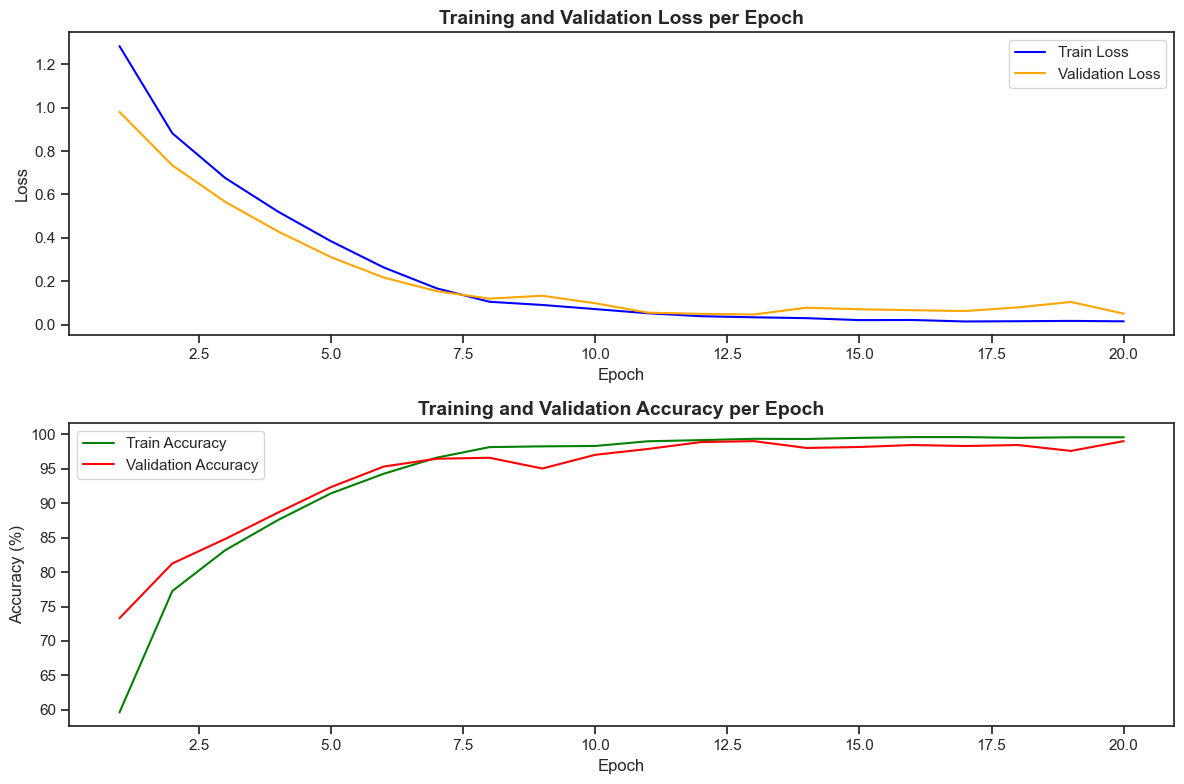

In [26]:
# Load the checkpoint
checkpoint_path = f"{MODEL_NAME}_last_checkpoint.pt" # Replace with your latest checkpoint file
checkpoint = torch.load(checkpoint_path)

# Extract metrics from the checkpoint
epochs = list(range(1, checkpoint["epoch"] + 1))
train_loss = checkpoint["train_loss"]
train_accuracy = checkpoint["train_accuracy"]
val_loss = checkpoint["val_loss"]
val_accuracy = checkpoint["val_accuracy"]

# Set Seaborn style for better aesthetics
sns.set_theme(style="ticks")

# Create a figure for visualizations
plt.figure(figsize=(12, 8))

# Plot training and validation loss
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title("Training and Validation Loss per Epoch", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()

# Plot training and validation accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy', color='green')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='red')
plt.title("Training and Validation Accuracy per Epoch", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.legend()

# Adjust spacing between plots
plt.tight_layout()

# Save the visualization as a file (optional)
output_plot_path = f"{MODEL_NAME}_training_visualization.png"
plt.savefig(output_plot_path, dpi=300)
print(f"Visualization saved to {output_plot_path}")

# Show the plots
plt.show()

In [36]:
def load_model_from_checkpoint(checkpoint_path, model_class, device):
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    # Load model weights
    model_co.load_state_dict(checkpoint["model_state_dict"])
    model_co.to(device)
    model_co.eval()  # Set to evaluation mode
    return model_co

In [37]:
# Predict on validation data
def predict(model_co, dataloader, device):
    model_co.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():  # No need to compute gradients for validation
        for inputs, labels in dataloader:  # Assuming dataloader is a dictionary with 'val' key
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Collect true and predicted labels
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return np.array(y_true), np.array(y_pred)

In [38]:
# Define paths and device
checkpoint_path = "Mobile_Pit_last_checkpoint.pt"
model_class=5
# Initialize and load the model (replace YourModel with your actual model class)
model = load_model_from_checkpoint(checkpoint_path, model_class, device)

/var/folders/yy/x1rxps2s2kb9r69ysncj7qs00000gn/T/ipykernel_93813/2197379667.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_

In [ ]:
# Define paths and device
checkpoint_path = "Mobile_Pit_last_checkpoint.pt"
model_class=5
# Initialize and load the model (replace YourModel with your actual model class)
model = load_model_from_checkpoint(checkpoint_path, model_class, device)

# Assuming `dataloaders` is a dictionary with 'val' key containing the validation dataloader
# Predict on validation set
y_true_train, y_pred_train = predict(model_co, train_loader, device)

y_true_val, y_pred_val = predict(model_co, val_loader, device)

/var/folders/yy/x1rxps2s2kb9r69ysncj7qs00000gn/T/ipykernel_92575/2197379667.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_

In [ ]:
train_accuracy= accuracy_score(y_true_train, y_pred_train)
print(f"Train Accuracy: {round(train_accuracy * 100, 2)}%")

In [53]:
Validation_accuracy = accuracy_score(y_true_val, y_pred_val)
print(f"Validation Accuracy: {round(Validation_accuracy * 100, 2)}%")

Validation Accuracy: 99.01%


In [54]:
report = classification_report(y_true_val, y_pred_val, digits=2)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       364
           1       0.98      1.00      0.99        80
           2       1.00      0.98      0.99       173
           3       0.90      1.00      0.95        35
           4       0.98      0.98      0.98        52

    accuracy                           0.99       704
   macro avg       0.97      0.99      0.98       704
weighted avg       0.99      0.99      0.99       704



In [55]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming y_true and y_pred are your true and predicted labels, respectively
level_to_category = {
    0: "No_DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}

# Map multiclass labels to binary labels
binary_y_true = [0 if label == 0 else 1 for label in y_true_val]
binary_y_pred = [0 if label == 0 else 1 for label in y_pred_val]

# Compute confusion matrix
cm = confusion_matrix(binary_y_true, binary_y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No_DR", "DR"], yticklabels=["No_DR", "DR"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Binary Classification)")
plt.savefig('confusion matrix swin as binary calssification', dpi=300)
plt.show()

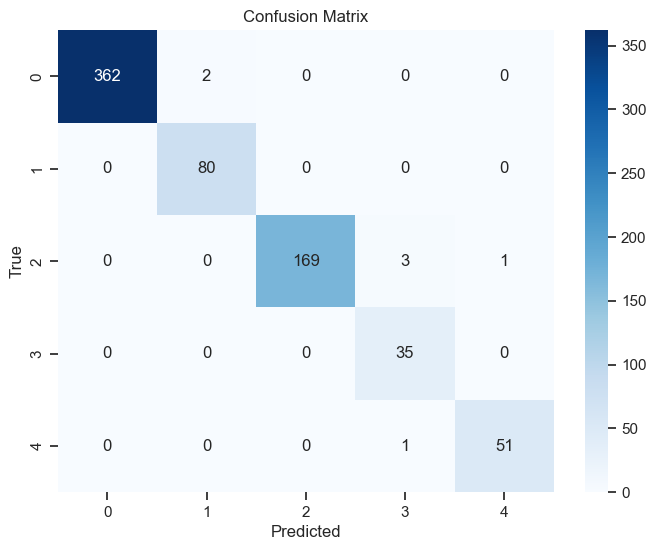

In [56]:
# Compute confusion matrix
cm = confusion_matrix(y_true_val, y_pred_val)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.arange(cm.shape[0]), yticklabels=np.arange(cm.shape[0]))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrixResnet50.png', bbox_inches='tight')
plt.show()

In [30]:
import torchvision.transforms as transforms

def predict_single_image(image_path, model, device):
    # Preprocess the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Adjust size if needed
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                             [0.229, 0.224, 0.225])  # ImageNet std
    ])
    
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    model.eval()
    with torch.no_grad():
        output = model(image)
        predicted_class = torch.argmax(output, dim=1).item()

    return predicted_class


In [31]:
image_path = "Dataset/train_images/0024cdab0c1e.png"
predicted_class = predict_single_image(image_path, model, device)
print("Predicted Class:", predicted_class)

Predicted Class: 1


In [31]:
torch.save(model.state_dict(), 'best_model_effnetb5_fold0.pth')

# UI

In [32]:
# Cell 1: Imports and Setup
import torch
import torch.nn as nn
import timm
import torchvision.transforms as transforms
from PIL import Image
import io
import ipywidgets as widgets
from IPython.display import display

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Class labels
class_names = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']

In [33]:
# Cell 2: Define Your Model Class (Same as Training)

class DRModel(nn.Module):
    def __init__(self, model_name='tf_efficientnet_b5_ns', out_features=5):
        super(DRModel, self).__init__()
        self.base_model = timm.create_model(model_name, pretrained=False)
        in_features = self.base_model.get_classifier().in_features
        self.base_model.classifier = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.base_model(x)


In [39]:
# Cell 3: Load Model from Checkpoint
# Load model
model_path = "Mobile_Pit_last_checkpoint.pt"
model = load_model_from_checkpoint(checkpoint_path, model_class, device)
print("✅ Model Loaded")


/var/folders/yy/x1rxps2s2kb9r69ysncj7qs00000gn/T/ipykernel_93813/2197379667.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_

✅ Model Loaded


In [40]:
# Cell 4: Prediction Function

def predict_image(image_pil, model, device):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    image = image_pil.convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image)
        pred_class = torch.argmax(outputs, dim=1).item()
    return pred_class


In [41]:
# Cell 5: Upload Widget + UI Interaction

upload_btn = widgets.FileUpload(
    accept='image/*',
    multiple=False
)

def on_upload_change(change):
    if upload_btn.value:
        file_info = list(upload_btn.value.values())[0]
        image_bytes = file_info['content']
        img = Image.open(io.BytesIO(image_bytes)).convert("RGB")
        display(img)

        pred_class = predict_image(img, model, device)
        print(f"🔍 Predicted Severity: **{class_names[pred_class]}**")

upload_btn.observe(on_upload_change, names='value')
display(widgets.Label("📤 Upload a retina image below:"))
display(upload_btn)


Label(value='📤 Upload a retina image below:')

FileUpload(value={}, accept='image/*', description='Upload')

In [42]:
from torchvision import transforms
import torch

# Class names
class_names = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']

def predict_image(img, model, device):
    """
    Predict diabetic retinopathy severity for a given PIL image.

    Args:
        img (PIL.Image): RGB image.
        model (nn.Module): Loaded PyTorch model.
        device (torch.device): 'cuda' or 'cpu'.

    Returns:
        int: predicted class index
        str: predicted class label
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    img_tensor = transform(img).unsqueeze(0).to(device)
    model.eval()

    with torch.no_grad():
        outputs = model(img_tensor)
        pred_class = torch.argmax(outputs, dim=1).item()

    return pred_class, class_names[pred_class]


In [43]:
img = Image.open("Dataset/train_images/001639a390f0.png").convert("RGB")
pred_class, label = predict_image(img, model, device)
print("Predicted:", label)

Predicted: Proliferate_DR
